In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import time 
import tqdm
from PIL import Image
train_on_gpu = True
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR
import tqdm
import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

from collections import OrderedDict
import cv2

c:\Users\COM\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!pip install --upgrade pip

In [3]:
!pip install pretrainedmodels > /dev/null

������ ��θ� ã�� �� �����ϴ�.


In [4]:
import pretrainedmodels

### Data overview

In [5]:
train_df = pd.read_csv("C:/Users/COM/Desktop/hlsw/final_project_md/whale-categorization-playground/train.csv")
train_df.head()

,Image,Id
0,00022e1a.jpg,w_e15442c
1,000466c4.jpg,w_1287fbc
2,00087b01.jpg,w_da2efe0
3,001296d5.jpg,w_19e5482
4,0014cfdf.jpg,w_f22f3e3


For train data we have a DataFrame with image names and ids. And of course for train and test we have images in separate folders.

In [6]:
print(f"There are {len(os.listdir('C:/Users/COM/Desktop/hlsw/final_project_md/whale-categorization-playground/train'))} images in train dataset with {train_df.Id.nunique()} unique classes.")
print(f"There are {len(os.listdir('C:/Users/COM/Desktop/hlsw/final_project_md/whale-categorization-playground/test'))} images in test dataset.")

There are 9850 images in train dataset with 4251 unique classes.
There are 15610 images in test dataset.


25k images in train and 5k different whales!
Let's have a look at them

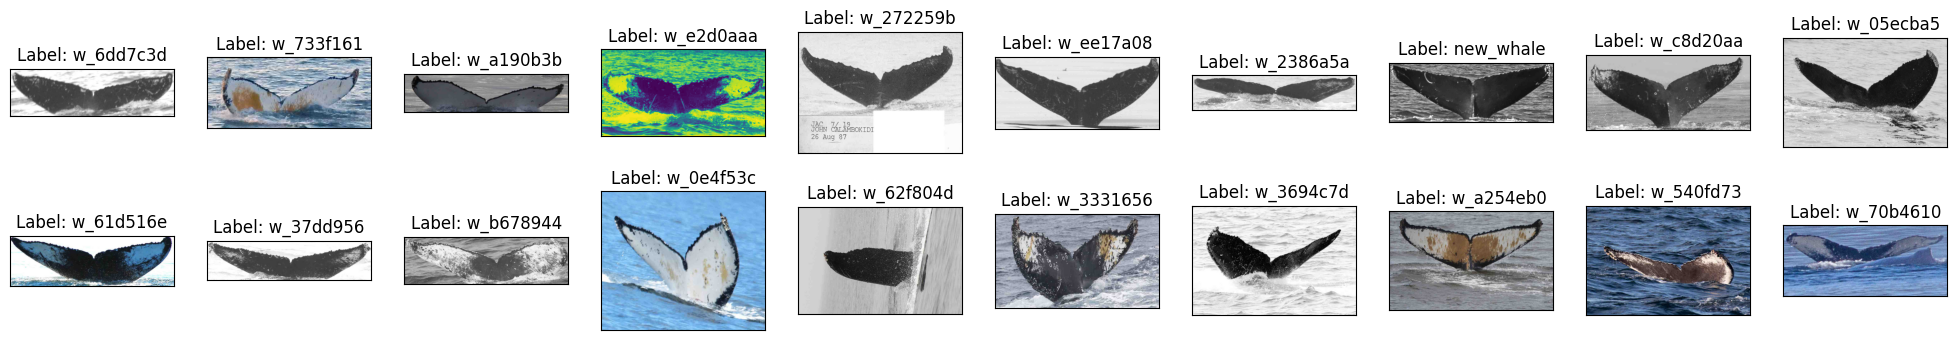

In [7]:
fig = plt.figure(figsize=(25, 4))
train_imgs = os.listdir("C:/Users/COM/Desktop/hlsw/final_project_md/whale-categorization-playground/train/")
for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open("C:/Users/COM/Desktop/hlsw/final_project_md/whale-categorization-playground/train/" + img)
    plt.imshow(im)
    lab = train_df.loc[train_df.Image == img, 'Id'].values[0]
    ax.set_title(f'Label: {lab}')

In [8]:
len(train_df.Id.value_counts())

4251

In [9]:
for i in range(1, 4):
    print(f'There are {train_df.Id.value_counts()[train_df.Id.value_counts().values==i].shape[0]} classes with {i} samples in train data.')

There are 2220 classes with 1 samples in train data.
There are 1034 classes with 2 samples in train data.
There are 492 classes with 3 samples in train data.


In [10]:
train_df_cnt = train_df.groupby('Id').agg('count').rename({'Image': 'NumImages'}, axis=1)
train_df_cnt.sort_values('NumImages', ascending=False, inplace=True)
train_df_cnt

,NumImages
Id,
new_whale,810
w_1287fbc,34
w_98baff9,27
w_7554f44,26
w_1eafe46,23
...,...
w_7e48479,1
w_7e728d8,1
w_7e8305f,1


In [11]:
train_new_whale = train_df[train_df.Id == "new_whale"].head(18)

In [12]:
train_df_cnt.drop('new_whale', inplace=True)
train_df_cnt

,NumImages
Id,
w_1287fbc,34
w_98baff9,27
w_7554f44,26
w_1eafe46,23
w_fd1cb9d,22
...,...
w_7e48479,1
w_7e728d8,1
w_7e8305f,1


In [13]:
NUM_IMAGES_THRESHOLD = 15

over15_df = train_df_cnt.query(f'NumImages > {NUM_IMAGES_THRESHOLD}')

print('shape:', over15_df.shape)
print('total number of images:', over15_df.NumImages.sum())
over15_df

shape: (24, 1)
total number of images: 481


,NumImages
Id,
w_1287fbc,34
w_98baff9,27
w_7554f44,26
w_1eafe46,23
w_fd1cb9d,22
w_ab4cae2,22
w_693c9ee,22
w_987a36f,21
w_43be268,21


In [14]:
len(over15_df)

24

In [15]:
ids_to_leave = list(over15_df.index)
train_df = train_df.query(f'Id in {ids_to_leave}')
train_df

,Image,Id
1,000466c4.jpg,w_1287fbc
13,00467ae9.jpg,w_fd1cb9d
62,01981e98.jpg,w_f19faeb
81,01ed89f6.jpg,w_67de30b
104,02916b71.jpg,w_73d5489
...,...,...
9740,fd30f7e6.jpg,w_9b401eb
9811,fefc845c.jpg,w_dbda0d6
9814,ff0de88a.jpg,w_18eee6e
9828,ff6946b4.jpg,w_17ee910


In [16]:
train_df.drop(train_df.query("Image == '496b52ff.jpg'").index,
                 axis=0, inplace=True)

train_df

,Image,Id
1,000466c4.jpg,w_1287fbc
13,00467ae9.jpg,w_fd1cb9d
62,01981e98.jpg,w_f19faeb
81,01ed89f6.jpg,w_67de30b
104,02916b71.jpg,w_73d5489
...,...,...
9740,fd30f7e6.jpg,w_9b401eb
9811,fefc845c.jpg,w_dbda0d6
9814,ff0de88a.jpg,w_18eee6e
9828,ff6946b4.jpg,w_17ee910


In [17]:
train_df = pd.concat([train_df, train_new_whale])
train_df

,Image,Id
1,000466c4.jpg,w_1287fbc
13,00467ae9.jpg,w_fd1cb9d
62,01981e98.jpg,w_f19faeb
81,01ed89f6.jpg,w_67de30b
104,02916b71.jpg,w_73d5489
...,...,...
148,03c6a5c0.jpg,new_whale
151,03de1a54.jpg,new_whale
184,04a39247.jpg,new_whale
187,04ad14b2.jpg,new_whale


In [18]:
final_train_df_cnt = train_df.groupby('Id').agg('count').rename({'Image': 'NumImages'}, axis=1)
final_train_df_cnt.sort_values('NumImages', ascending=False, inplace=True)
final_train_df_cnt

,NumImages
Id,
w_1287fbc,34
w_98baff9,26
w_7554f44,26
w_1eafe46,23
w_fd1cb9d,22
w_ab4cae2,22
w_693c9ee,22
w_987a36f,21
w_43be268,21


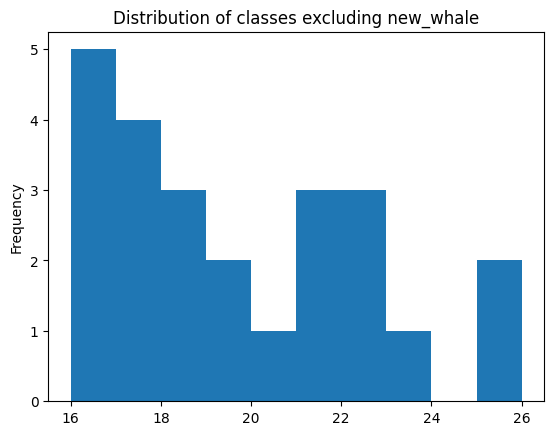

In [19]:
plt.title('Distribution of classes excluding new_whale');
train_df.Id.value_counts()[1:].plot(kind='hist');

We can see that there is a huge disbalance in the data. There are many classes with only one or several samples , some classes have 50+ samples and "default" class has almost 10k samples.

In [20]:
np.array(im).shape

(450, 1050, 3)

At least some images are quite big

### Preparing data for Pytorch
Data for Pytorch needs to be prepared:
* we need to define transformations;
* then we need to initialize a dataset class;
* then we need to create dataloaders which will be used by the model;

#### Transformations

Basic transformations include only resizing the image to the necessary size, converting to Pytorch tensor and normalizing

In [21]:
train_df.shape

(498, 2)

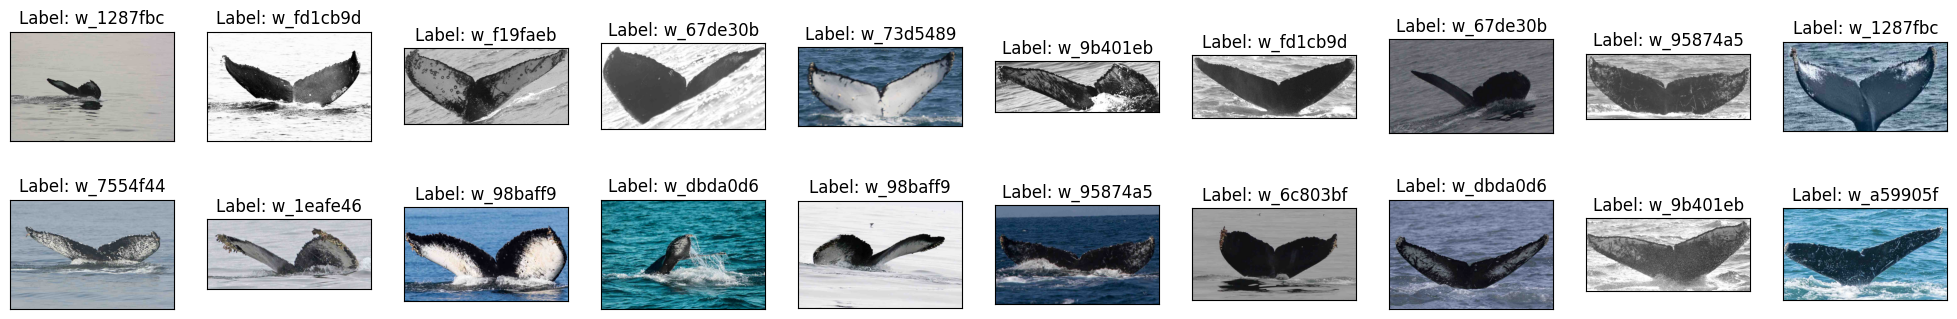

In [22]:
fig = plt.figure(figsize=(25, 4))
# train_imgs = os.listdir("C:/Users/COM/Desktop/hlsw/final_project_md/whale-categorization-playground/train/")
# for idx, img in enumerate(train_imgs):
for idx, img in enumerate(train_df.Image[:20]):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open("C:/Users/COM/Desktop/hlsw/final_project_md/whale-categorization-playground/train/" + img)
    plt.imshow(im)
    lab = train_df.loc[train_df.Image == img, 'Id'].values[0]
    ax.set_title(f'Label: {lab}')

In [23]:
data_transforms = transforms.Compose([
                                      transforms.Resize((224, 224)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                             std=[0.229, 0.224, 0.225])
    ])
data_transforms_test = transforms.Compose([
                                           transforms.Resize((224, 224)),
                                           transforms.RandomHorizontalFlip(),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                 std=[0.229, 0.224, 0.225])
])

#### Encoding labels
Labels need to be one-hot encoded.

In [24]:
def prepare_labels(y):
    # From here: https://www.kaggle.com/pestipeti/keras-cnn-starter
    values = np.array(y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)

    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

    y = onehot_encoded
    return y, label_encoder

In [25]:
y, le = prepare_labels(train_df['Id'])

c:\Users\COM\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


#### Dataset

Now we need to create a dataset. Sadly, default version won't work, as images for each class are supposed to be in separate folders. So I write a custom WhaleDataset.

In [26]:
class WhaleDataset(Dataset):
    def __init__(self, datafolder, datatype='train', df=None, transform = transforms.Compose([transforms.ToTensor()]), y=None):
        self.datafolder = datafolder
        self.datatype = datatype
        self.y = y
        if self.datatype == 'train':
            self.df = df.values
            self.image_files_list = [self.datafolder + s for s in self.df[:,0]]
        else:
            self.image_files_list = [s for s in os.listdir(datafolder)]
        self.transform = transform


    def __len__(self):
        return len(self.image_files_list)
    
    def __getitem__(self, idx):
        if self.datatype == 'train':
            img_name = os.path.join(self.datafolder, self.df[idx][0])
            label = self.y[idx]
            
        elif self.datatype == 'test':
            img_name = os.path.join(self.datafolder, self.image_files_list[idx])
            label = np.zeros((5005,))

        image = Image.open(img_name).convert('RGB')
        image = self.transform(image)
        if self.datatype == 'train':
            return image, label
        elif self.datatype == 'test':
            # so that the images will be in a correct order
            return image, label, self.image_files_list[idx]

In [27]:
train_dataset = WhaleDataset(datafolder='C:/Users/COM/Desktop/hlsw/final_project_md/whale-categorization-playground/train/', datatype='train', df=train_df, transform=data_transforms, y=y)
test_set = WhaleDataset(datafolder='C:/Users/COM/Desktop/hlsw/final_project_md/whale-categorization-playground/test/', datatype='test', transform=data_transforms_test)

In [28]:
len(train_dataset)

498

In [29]:
from torch.utils.data import random_split

train_size = 0.75
num_train = int(len(train_df) * train_size)
num_val = len(train_df) - num_train

train_dataset, validation_dataset = random_split(train_dataset, [num_train, num_val])

In [30]:
len(train_dataset), len(validation_dataset)

(373, 125)

#### Loaders

Now we create loaders. Here we define which images will be used, batch size and other things.

In [31]:
valid_sampler = SubsetRandomSampler(list(range(len(os.listdir('C:/Users/COM/Desktop/hlsw/final_project_md/whale-categorization-playground/test/')))))
batch_size = 64
num_workers = 0

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
# less size for test loader.
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, sampler=valid_sampler, num_workers=num_workers)

#### Initializing model

In [32]:
model_conv = models.resnet18(pretrained=True) # 모델의 객체 생성

model_conv.fc = nn.Linear(512, 25)

for i, (name, param) in enumerate(model_conv.named_parameters()):
    param.requires_grad = False
    if i == 59:
        print('end')
        break

optimizer = optim.Adam(model_conv.parameters(), lr=0.01)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
criterion = nn.CrossEntropyLoss() # 손실 함수 정의
print(model_conv)

c:\Users\COM\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\COM\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


end
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True

But this was an example. The basic model isn't really good. You can try it, but it is much better to use pre-trained models.

In [33]:
# 전체 모델의 파라미터를 확인하면서 requires_grad 값을 출력
for idx, (name, param) in enumerate(model_conv.fc.named_parameters()):
    print(f"{name}: requires_grad={param.requires_grad}")

weight: requires_grad=True
bias: requires_grad=True


In [34]:
# 전체 모델의 파라미터를 확인하면서 requires_grad 값을 출력
for idx, (name, param) in enumerate(list(model_conv.named_parameters())):
    print(f"{name}: requires_grad={param.requires_grad}")

conv1.weight: requires_grad=False
bn1.weight: requires_grad=False
bn1.bias: requires_grad=False
layer1.0.conv1.weight: requires_grad=False
layer1.0.bn1.weight: requires_grad=False
layer1.0.bn1.bias: requires_grad=False
layer1.0.conv2.weight: requires_grad=False
layer1.0.bn2.weight: requires_grad=False
layer1.0.bn2.bias: requires_grad=False
layer1.1.conv1.weight: requires_grad=False
layer1.1.bn1.weight: requires_grad=False
layer1.1.bn1.bias: requires_grad=False
layer1.1.conv2.weight: requires_grad=False
layer1.1.bn2.weight: requires_grad=False
layer1.1.bn2.bias: requires_grad=False
layer2.0.conv1.weight: requires_grad=False
layer2.0.bn1.weight: requires_grad=False
layer2.0.bn1.bias: requires_grad=False
layer2.0.conv2.weight: requires_grad=False
layer2.0.bn2.weight: requires_grad=False
layer2.0.bn2.bias: requires_grad=False
layer2.0.downsample.0.weight: requires_grad=False
layer2.0.downsample.1.weight: requires_grad=False
layer2.0.downsample.1.bias: requires_grad=False
layer2.1.conv1.wei

In [35]:
model_conv=model_conv.cuda()
n_epochs = 20

train_loss = torch.zeros(n_epochs)
valid_loss = torch.zeros(n_epochs)

train_acc = torch.zeros(n_epochs)
valid_acc = torch.zeros(n_epochs)

valid_loss_min = np.Inf

for epoch in range(0, n_epochs):
    model_conv.train()
    exp_lr_scheduler.step()

    for batch_i, (data, target) in enumerate(tqdm.tqdm(train_loader)):
        data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output = model_conv(data)
        loss = criterion(output, target.float())
        loss.backward()
        optimizer.step()
        train_loss[epoch] += loss.item()
        
        # ps의 shape: (배치 크기, 클래스 개수)
        ps = F.softmax(output, dim=1)

        # top_p의 shape: (배치 크기, 1), top_class의 shape: (배치 크기, 1)
        top_p, top_class = ps.topk(1, dim=1)
        top_class = top_class.cpu()
        equals = top_class == np.argmax(target.cpu(), axis=1).reshape(top_class.shape)
        # train_acc의 shape: scalar (텐서이지만 스칼라 값)
        train_acc[epoch] += torch.mean(equals.type(torch.float)).detach().cpu()
            
    train_loss[epoch] /= len(train_loader)
    train_acc[epoch] /= len(train_loader)
    
    with torch.no_grad(): 
        model_conv.eval()
        for batch_i, (data, target) in enumerate(tqdm.tqdm(valid_loader)):
            data, target = data.cuda(), target.cuda()

            output = model_conv(data)
            loss = criterion(output, target.float())
            valid_loss[epoch] += loss.item()

            ps = F.softmax(output, dim=1)
            top_p, top_class = ps.topk(1, dim=1)
            top_class = top_class.cpu()
            equals = top_class == np.argmax(target.cpu(), axis=1).reshape(top_class.shape)
            valid_acc[epoch] += torch.mean(equals.type(torch.float)).detach().cpu()
    
    # calculate average losses
    valid_loss[epoch] /= len(valid_loader)
    valid_acc[epoch] /= len(valid_loader)
    
    # exp_lr_scheduler.step()
    
    print(f'Epoch {epoch+1}, train loss: {train_loss[epoch]:.4f}, train acc: {train_acc[epoch]:.4f}')
    print(f'Epoch {epoch+1}, valid loss: {valid_loss[epoch]:.4f}, valid acc: {valid_acc[epoch]:.4f}')   
    
    if valid_loss[epoch] <= valid_loss_min: # valid_loss가 더 작을경우 모델 저장
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss[epoch]))
        torch.save(model_conv, 'small_model.pt')
        torch.save(model_conv.state_dict(), 'small_model_state.pt')
        valid_loss_min = valid_loss[epoch]
    
        
 


c:\Users\COM\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\optim\lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
100%|██████████| 2/2 [00:00<00:00,  3.27it/s]


Epoch 1, train loss: 4.4271, train acc: 0.0850
Epoch 1, valid loss: 4.5229, valid acc: 0.0871
Validation loss decreased (inf --> 4.522877).  Saving model ...


100%|██████████| 2/2 [00:00<00:00,  3.07it/s]


Epoch 2, train loss: 2.9085, train acc: 0.3140
Epoch 2, valid loss: 3.0270, valid acc: 0.2975
Validation loss decreased (4.522877 --> 3.027044).  Saving model ...


100%|██████████| 2/2 [00:00<00:00,  2.89it/s]


Epoch 3, train loss: 2.1409, train acc: 0.4313
Epoch 3, valid loss: 2.5248, valid acc: 0.3604
Validation loss decreased (3.027044 --> 2.524755).  Saving model ...


100%|██████████| 2/2 [00:00<00:00,  2.91it/s]


Epoch 4, train loss: 1.5201, train acc: 0.5933
Epoch 4, valid loss: 2.0839, valid acc: 0.4486
Validation loss decreased (2.524755 --> 2.083902).  Saving model ...


100%|██████████| 2/2 [00:00<00:00,  2.88it/s]


Epoch 5, train loss: 1.2195, train acc: 0.7174
Epoch 5, valid loss: 1.9595, valid acc: 0.5041
Validation loss decreased (2.083902 --> 1.959542).  Saving model ...


100%|██████████| 2/2 [00:00<00:00,  2.91it/s]


Epoch 6, train loss: 1.1383, train acc: 0.7675
Epoch 6, valid loss: 1.9863, valid acc: 0.4978


100%|██████████| 2/2 [00:00<00:00,  2.90it/s]


Epoch 7, train loss: 1.1389, train acc: 0.7419
Epoch 7, valid loss: 1.9983, valid acc: 0.5022


100%|██████████| 2/2 [00:00<00:00,  2.91it/s]


Epoch 8, train loss: 1.1285, train acc: 0.7601
Epoch 8, valid loss: 1.9979, valid acc: 0.4963


100%|██████████| 2/2 [00:00<00:00,  2.89it/s]


Epoch 9, train loss: 1.1051, train acc: 0.7831
Epoch 9, valid loss: 1.9295, valid acc: 0.5272
Validation loss decreased (1.959542 --> 1.929549).  Saving model ...


100%|██████████| 2/2 [00:00<00:00,  2.91it/s]


Epoch 10, train loss: 1.1073, train acc: 0.7758
Epoch 10, valid loss: 1.9582, valid acc: 0.5041


100%|██████████| 2/2 [00:00<00:00,  2.88it/s]


Epoch 11, train loss: 1.1017, train acc: 0.7841
Epoch 11, valid loss: 1.9631, valid acc: 0.5026


100%|██████████| 2/2 [00:00<00:00,  2.83it/s]


Epoch 12, train loss: 1.1130, train acc: 0.7768
Epoch 12, valid loss: 1.9455, valid acc: 0.5201


100%|██████████| 2/2 [00:00<00:00,  2.87it/s]


Epoch 13, train loss: 1.0906, train acc: 0.7743
Epoch 13, valid loss: 1.9630, valid acc: 0.5424


100%|██████████| 2/2 [00:00<00:00,  2.97it/s]


Epoch 14, train loss: 1.1134, train acc: 0.7758
Epoch 14, valid loss: 1.9593, valid acc: 0.5045


100%|██████████| 2/2 [00:00<00:00,  2.84it/s]


Epoch 15, train loss: 1.0902, train acc: 0.7894
Epoch 15, valid loss: 1.9208, valid acc: 0.5197
Validation loss decreased (1.929549 --> 1.920846).  Saving model ...


100%|██████████| 2/2 [00:00<00:00,  2.82it/s]


Epoch 16, train loss: 1.1033, train acc: 0.7946
Epoch 16, valid loss: 1.9742, valid acc: 0.5435


100%|██████████| 2/2 [00:00<00:00,  2.86it/s]


Epoch 17, train loss: 1.1223, train acc: 0.7660
Epoch 17, valid loss: 1.9493, valid acc: 0.4967


100%|██████████| 2/2 [00:00<00:00,  2.78it/s]


Epoch 18, train loss: 1.1021, train acc: 0.7711
Epoch 18, valid loss: 1.9515, valid acc: 0.5279


100%|██████████| 2/2 [00:00<00:00,  2.91it/s]


Epoch 19, train loss: 1.0849, train acc: 0.7758
Epoch 19, valid loss: 1.9356, valid acc: 0.5178


100%|██████████| 2/2 [00:00<00:00,  2.92it/s]

Epoch 20, train loss: 1.0893, train acc: 0.7727
Epoch 20, valid loss: 1.9474, valid acc: 0.5283


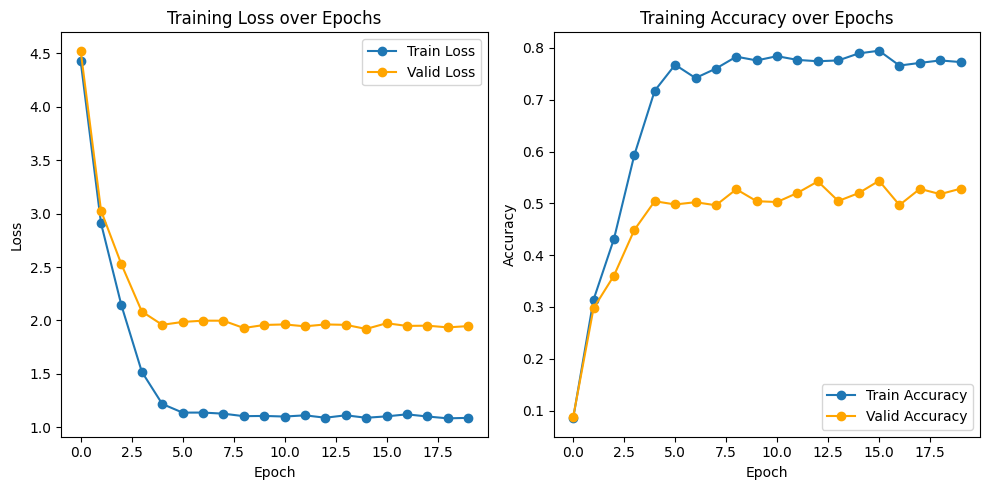

In [36]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(n_epochs), train_loss, label='Train Loss', marker='o')
plt.plot(range(n_epochs), valid_loss, label='Valid Loss', marker='o', color='orange')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Train Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(range(n_epochs), train_acc, label='Train Accuracy', marker='o')
plt.plot(range(n_epochs), valid_acc, label='Valid Accuracy', marker='o', color='orange')
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

#### Apply fine-tuning, that is, unfreeze the base model and train the whole model with a small learning rate

In [37]:
model_conv.load_state_dict(torch.load('small_model_state.pt')) # 가장 좋았던 모델 값 불러오기.

<All keys matched successfully>

In [38]:
for i, (name, param) in enumerate(model_conv.named_parameters()):
    param.requires_grad = True
    if i == 158:
        print('end')
        break

In [39]:
# 전체 모델의 파라미터를 확인하면서 requires_grad 값을 출력
for name, param in model_conv.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

conv1.weight: requires_grad=True
bn1.weight: requires_grad=True
bn1.bias: requires_grad=True
layer1.0.conv1.weight: requires_grad=True
layer1.0.bn1.weight: requires_grad=True
layer1.0.bn1.bias: requires_grad=True
layer1.0.conv2.weight: requires_grad=True
layer1.0.bn2.weight: requires_grad=True
layer1.0.bn2.bias: requires_grad=True
layer1.1.conv1.weight: requires_grad=True
layer1.1.bn1.weight: requires_grad=True
layer1.1.bn1.bias: requires_grad=True
layer1.1.conv2.weight: requires_grad=True
layer1.1.bn2.weight: requires_grad=True
layer1.1.bn2.bias: requires_grad=True
layer2.0.conv1.weight: requires_grad=True
layer2.0.bn1.weight: requires_grad=True
layer2.0.bn1.bias: requires_grad=True
layer2.0.conv2.weight: requires_grad=True
layer2.0.bn2.weight: requires_grad=True
layer2.0.bn2.bias: requires_grad=True
layer2.0.downsample.0.weight: requires_grad=True
layer2.0.downsample.1.weight: requires_grad=True
layer2.0.downsample.1.bias: requires_grad=True
layer2.1.conv1.weight: requires_grad=True


#### 모든 파라미터에 대해 새로 학습

In [40]:
model_conv=model_conv.cuda()
n_epochs = 20

train_loss = torch.zeros(n_epochs)
valid_loss = torch.zeros(n_epochs)

train_acc = torch.zeros(n_epochs)
valid_acc = torch.zeros(n_epochs)

valid_loss_min = np.Inf

for epoch in range(0, n_epochs):
    model_conv.train()
    exp_lr_scheduler.step()

    for batch_i, (data, target) in enumerate(tqdm.tqdm(train_loader)):
        data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output = model_conv(data)
        loss = criterion(output, target.float())
        loss.backward()
        optimizer.step()
        train_loss[epoch] += loss.item()
        
        # ps의 shape: (배치 크기, 클래스 개수)
        ps = F.softmax(output, dim=1)

        # top_p의 shape: (배치 크기, 1), top_class의 shape: (배치 크기, 1)
        top_p, top_class = ps.topk(1, dim=1)
        top_class = top_class.cpu()
        equals = top_class == np.argmax(target.cpu(), axis=1).reshape(top_class.shape)
        # train_acc의 shape: scalar (텐서이지만 스칼라 값)
        train_acc[epoch] += torch.mean(equals.type(torch.float)).detach().cpu()
            
    train_loss[epoch] /= len(train_loader)
    train_acc[epoch] /= len(train_loader)
    
    with torch.no_grad(): 
        model_conv.eval()
        for batch_i, (data, target) in enumerate(tqdm.tqdm(valid_loader)):
            data, target = data.cuda(), target.cuda()

            output = model_conv(data)
            loss = criterion(output, target.float())
            valid_loss[epoch] += loss.item()

            ps = F.softmax(output, dim=1)
            top_p, top_class = ps.topk(1, dim=1)
            top_class = top_class.cpu()
            equals = top_class == np.argmax(target.cpu(), axis=1).reshape(top_class.shape)
            valid_acc[epoch] += torch.mean(equals.type(torch.float)).detach().cpu()
    
    # calculate average losses
    valid_loss[epoch] /= len(valid_loader)
    valid_acc[epoch] /= len(valid_loader)
    
    # exp_lr_scheduler.step()
    
    print(f'Epoch {epoch+1}, train loss: {train_loss[epoch]:.4f}, train acc: {train_acc[epoch]:.4f}')
    print(f'Epoch {epoch+1}, valid loss: {valid_loss[epoch]:.4f}, valid acc: {valid_acc[epoch]:.4f}')   
    
    if valid_loss[epoch] <= valid_loss_min: # valid_loss가 더 작을경우 모델 저장
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss[epoch]))
        torch.save(model_conv, 'small_model.pt')
        torch.save(model_conv.state_dict(), 'small_model_state.pt')
        valid_loss_min = valid_loss[epoch]
    
        
 


100%|██████████| 2/2 [00:00<00:00,  3.25it/s]


Epoch 1, train loss: 1.0712, train acc: 0.7878
Epoch 1, valid loss: 1.9353, valid acc: 0.4947
Validation loss decreased (inf --> 1.935313).  Saving model ...


100%|██████████| 2/2 [00:00<00:00,  3.26it/s]


Epoch 2, train loss: 1.0917, train acc: 0.7749
Epoch 2, valid loss: 1.9653, valid acc: 0.5096


100%|██████████| 2/2 [00:00<00:00,  3.22it/s]


Epoch 3, train loss: 1.0814, train acc: 0.7680
Epoch 3, valid loss: 1.9420, valid acc: 0.5279


100%|██████████| 2/2 [00:00<00:00,  3.27it/s]


Epoch 4, train loss: 1.0990, train acc: 0.7806
Epoch 4, valid loss: 1.9311, valid acc: 0.5201
Validation loss decreased (1.935313 --> 1.931140).  Saving model ...


100%|██████████| 2/2 [00:00<00:00,  3.20it/s]


Epoch 5, train loss: 1.0984, train acc: 0.7617
Epoch 5, valid loss: 1.9553, valid acc: 0.5209


100%|██████████| 2/2 [00:00<00:00,  3.25it/s]


Epoch 6, train loss: 1.0998, train acc: 0.7623
Epoch 6, valid loss: 1.9365, valid acc: 0.5298


100%|██████████| 2/2 [00:00<00:00,  3.25it/s]


Epoch 7, train loss: 1.0983, train acc: 0.7936
Epoch 7, valid loss: 1.9566, valid acc: 0.5279


100%|██████████| 2/2 [00:00<00:00,  3.24it/s]


Epoch 8, train loss: 1.1073, train acc: 0.7654
Epoch 8, valid loss: 1.9245, valid acc: 0.5190
Validation loss decreased (1.931140 --> 1.924538).  Saving model ...


100%|██████████| 2/2 [00:00<00:00,  3.29it/s]


Epoch 9, train loss: 1.1079, train acc: 0.7539
Epoch 9, valid loss: 1.9619, valid acc: 0.5134


100%|██████████| 2/2 [00:00<00:00,  3.04it/s]


Epoch 10, train loss: 1.1072, train acc: 0.7617
Epoch 10, valid loss: 1.9711, valid acc: 0.5022


100%|██████████| 2/2 [00:00<00:00,  3.28it/s]


Epoch 11, train loss: 1.1078, train acc: 0.7717
Epoch 11, valid loss: 1.9590, valid acc: 0.5041


100%|██████████| 2/2 [00:00<00:00,  3.28it/s]


Epoch 12, train loss: 1.1052, train acc: 0.7658
Epoch 12, valid loss: 1.9300, valid acc: 0.5291


100%|██████████| 2/2 [00:00<00:00,  3.23it/s]


Epoch 13, train loss: 1.0957, train acc: 0.7513
Epoch 13, valid loss: 1.9492, valid acc: 0.5216


100%|██████████| 2/2 [00:00<00:00,  3.26it/s]


Epoch 14, train loss: 1.1108, train acc: 0.7472
Epoch 14, valid loss: 1.9734, valid acc: 0.5197


100%|██████████| 2/2 [00:00<00:00,  3.18it/s]


Epoch 15, train loss: 1.0833, train acc: 0.7685
Epoch 15, valid loss: 1.9560, valid acc: 0.5365


100%|██████████| 2/2 [00:00<00:00,  3.20it/s]


Epoch 16, train loss: 1.1049, train acc: 0.7784
Epoch 16, valid loss: 1.9780, valid acc: 0.5268


100%|██████████| 2/2 [00:00<00:00,  3.16it/s]


Epoch 17, train loss: 1.1200, train acc: 0.7764
Epoch 17, valid loss: 1.9737, valid acc: 0.4959


100%|██████████| 2/2 [00:00<00:00,  3.24it/s]


Epoch 18, train loss: 1.1084, train acc: 0.7502
Epoch 18, valid loss: 1.9362, valid acc: 0.5361


100%|██████████| 2/2 [00:00<00:00,  3.25it/s]


Epoch 19, train loss: 1.1015, train acc: 0.7539
Epoch 19, valid loss: 1.9373, valid acc: 0.4978


100%|██████████| 2/2 [00:00<00:00,  3.20it/s]

Epoch 20, train loss: 1.1161, train acc: 0.7597
Epoch 20, valid loss: 1.9550, valid acc: 0.5283


In [41]:
model_conv.load_state_dict(torch.load('small_model_state.pt')) # 가장 좋았던 모델 값 불러오기.

<All keys matched successfully>

In [42]:
train_df = pd.read_csv("C:/Users/COM/Desktop/hlsw/final_project_md/whale-categorization-playground/train.csv")
train_df.head()

,Image,Id
0,00022e1a.jpg,w_e15442c
1,000466c4.jpg,w_1287fbc
2,00087b01.jpg,w_da2efe0
3,001296d5.jpg,w_19e5482
4,0014cfdf.jpg,w_f22f3e3


In [43]:
train_df.drop(train_df.query("Image == '496b52ff.jpg'").index,
                 axis=0, inplace=True)

train_df

,Image,Id
0,00022e1a.jpg,w_e15442c
1,000466c4.jpg,w_1287fbc
2,00087b01.jpg,w_da2efe0
3,001296d5.jpg,w_19e5482
4,0014cfdf.jpg,w_f22f3e3
...,...,...
9845,ffe5c306.jpg,w_2ceab05
9846,ffeaa7a4.jpg,w_b067417
9847,ffecec63.jpg,w_8b56cb1
9848,fff04277.jpg,w_2dcbf82


In [44]:
data_transforms = transforms.Compose([
                                      transforms.Resize((224, 224)),
                                      transforms.RandomHorizontalFlip(),
                                    #   transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                             std=[0.229, 0.224, 0.225])
    ])
data_transforms_test = transforms.Compose([
                                           transforms.Resize((224, 224)),
                                           transforms.RandomHorizontalFlip(),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                 std=[0.229, 0.224, 0.225])
])

In [45]:
def prepare_labels(y):
    # From here: https://www.kaggle.com/pestipeti/keras-cnn-starter
    values = np.array(y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)

    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

    y = onehot_encoded
    return y, label_encoder

In [46]:
y, le = prepare_labels(train_df['Id'])

c:\Users\COM\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [47]:
class WhaleDataset(Dataset):
    def __init__(self, datafolder, datatype='train', df=None, transform = transforms.Compose([transforms.ToTensor()]), y=None):
        self.datafolder = datafolder
        self.datatype = datatype
        self.y = y
        if self.datatype == 'train':
            self.df = df.values
            self.image_files_list = [self.datafolder + s for s in self.df[:,0]]
        else:
            self.image_files_list = [s for s in os.listdir(datafolder)]
        self.transform = transform


    def __len__(self):
        return len(self.image_files_list)
    
    def __getitem__(self, idx):
        if self.datatype == 'train':
            img_name = os.path.join(self.datafolder, self.df[idx][0])
            label = self.y[idx]
            
        elif self.datatype == 'test':
            img_name = os.path.join(self.datafolder, self.image_files_list[idx])
            label = np.zeros((5005,))

        image = Image.open(img_name).convert('RGB')
        image = self.transform(image)
        if self.datatype == 'train':
            return image, label
        elif self.datatype == 'test':
            # so that the images will be in a correct order
            return image, label, self.image_files_list[idx]

In [48]:
train_dataset = WhaleDataset(datafolder='C:/Users/COM/Desktop/hlsw/final_project_md/whale-categorization-playground/train/', datatype='train', df=train_df, transform=data_transforms, y=y)
test_set = WhaleDataset(datafolder='C:/Users/COM/Desktop/hlsw/final_project_md/whale-categorization-playground/test/', datatype='test', transform=data_transforms_test)

In [49]:
from torch.utils.data import random_split

train_size = 0.8
num_train = int(len(train_df) * train_size)
num_val = len(train_df) - num_train

train_dataset, validation_dataset = random_split(train_dataset, [num_train, num_val])

In [50]:
valid_sampler = SubsetRandomSampler(list(range(len(os.listdir('C:/Users/COM/Desktop/hlsw/final_project_md/whale-categorization-playground/test/')))))
batch_size = 64
num_workers = 0

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
# less size for test loader.
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, sampler=valid_sampler, num_workers=num_workers)

In [51]:
for i, (name, param) in enumerate(model_conv.named_parameters()):
    param.requires_grad = False
    if i == 59:
        print('end')
        break

end


In [52]:
# 전체 모델의 파라미터를 확인하면서 requires_grad 값을 출력
for name, param in model_conv.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

conv1.weight: requires_grad=False
bn1.weight: requires_grad=False
bn1.bias: requires_grad=False
layer1.0.conv1.weight: requires_grad=False
layer1.0.bn1.weight: requires_grad=False
layer1.0.bn1.bias: requires_grad=False
layer1.0.conv2.weight: requires_grad=False
layer1.0.bn2.weight: requires_grad=False
layer1.0.bn2.bias: requires_grad=False
layer1.1.conv1.weight: requires_grad=False
layer1.1.bn1.weight: requires_grad=False
layer1.1.bn1.bias: requires_grad=False
layer1.1.conv2.weight: requires_grad=False
layer1.1.bn2.weight: requires_grad=False
layer1.1.bn2.bias: requires_grad=False
layer2.0.conv1.weight: requires_grad=False
layer2.0.bn1.weight: requires_grad=False
layer2.0.bn1.bias: requires_grad=False
layer2.0.conv2.weight: requires_grad=False
layer2.0.bn2.weight: requires_grad=False
layer2.0.bn2.bias: requires_grad=False
layer2.0.downsample.0.weight: requires_grad=False
layer2.0.downsample.1.weight: requires_grad=False
layer2.0.downsample.1.bias: requires_grad=False
layer2.1.conv1.wei

In [53]:
model_conv.fc = nn.Linear(512, 4251)

optimizer = optim.Adam(model_conv.fc.parameters(), lr=0.01)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
criterion = nn.CrossEntropyLoss() # 손실 함수 정의
print(model_conv)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [54]:
model_conv=model_conv.cuda()
n_epochs = 20

train_loss = torch.zeros(n_epochs)
valid_loss = torch.zeros(n_epochs)

train_acc = torch.zeros(n_epochs)
valid_acc = torch.zeros(n_epochs)

valid_loss_min = np.Inf

for epoch in range(0, n_epochs):
    model_conv.train()
    exp_lr_scheduler.step()

    for batch_i, (data, target) in enumerate(tqdm.tqdm(train_loader)):
        data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output = model_conv(data)
        loss = criterion(output, target.float())
        loss.backward()
        optimizer.step()
        train_loss[epoch] += loss.item()
        
        # ps의 shape: (배치 크기, 클래스 개수)
        ps = F.softmax(output, dim=1)

        # top_p의 shape: (배치 크기, 1), top_class의 shape: (배치 크기, 1)
        top_p, top_class = ps.topk(1, dim=1)
        top_class = top_class.cpu()
        equals = top_class == np.argmax(target.cpu(), axis=1).reshape(top_class.shape)
        # train_acc의 shape: scalar (텐서이지만 스칼라 값)
        train_acc[epoch] += torch.mean(equals.type(torch.float)).detach().cpu()
            
    train_loss[epoch] /= len(train_loader)
    train_acc[epoch] /= len(train_loader)
    
    with torch.no_grad(): 
        model_conv.eval()
        for batch_i, (data, target) in enumerate(tqdm.tqdm(valid_loader)):
            data, target = data.cuda(), target.cuda()

            output = model_conv(data)
            loss = criterion(output, target.float())
            valid_loss[epoch] += loss.item()

            ps = F.softmax(output, dim=1)
            top_p, top_class = ps.topk(1, dim=1)
            top_class = top_class.cpu()
            equals = top_class == np.argmax(target.cpu(), axis=1).reshape(top_class.shape)
            valid_acc[epoch] += torch.mean(equals.type(torch.float)).detach().cpu()
    
    # calculate average losses
    valid_loss[epoch] /= len(valid_loader)
    valid_acc[epoch] /= len(valid_loader)
    
    # exp_lr_scheduler.step()
    
    print(f'Epoch {epoch+1}, train loss: {train_loss[epoch]:.4f}, train acc: {train_acc[epoch]:.4f}')
    print(f'Epoch {epoch+1}, valid loss: {valid_loss[epoch]:.4f}, valid acc: {valid_acc[epoch]:.4f}')   
    
    if valid_loss[epoch] <= valid_loss_min: # valid_loss가 더 작을경우 모델 저장
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss[epoch]))
        torch.save(model_conv, 'big_model.pt')
        torch.save(model_conv.state_dict(), 'big_model_state.pt')
        valid_loss_min = valid_loss[epoch]

c:\Users\COM\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\optim\lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
100%|██████████| 31/31 [00:10<00:00,  3.03it/s]


Epoch 1, train loss: 14.0412, train acc: 0.0567
Epoch 1, valid loss: 13.3421, valid acc: 0.0290
Validation loss decreased (inf --> 13.342063).  Saving model ...


100%|██████████| 31/31 [00:10<00:00,  3.06it/s]


Epoch 2, train loss: 6.8739, train acc: 0.1801
Epoch 2, valid loss: 15.4206, valid acc: 0.0695


100%|██████████| 31/31 [00:10<00:00,  3.04it/s]


Epoch 3, train loss: 2.2355, train acc: 0.6810
Epoch 3, valid loss: 9.9111, valid acc: 0.1759
Validation loss decreased (13.342063 --> 9.911059).  Saving model ...


100%|██████████| 31/31 [00:10<00:00,  3.04it/s]


Epoch 4, train loss: 0.8022, train acc: 0.8593
Epoch 4, valid loss: 9.4375, valid acc: 0.1936
Validation loss decreased (9.911059 --> 9.437535).  Saving model ...


100%|██████████| 31/31 [00:10<00:00,  3.08it/s]


Epoch 5, train loss: 0.4935, train acc: 0.9057
Epoch 5, valid loss: 9.3346, valid acc: 0.1968
Validation loss decreased (9.437535 --> 9.334630).  Saving model ...


100%|██████████| 31/31 [00:10<00:00,  3.07it/s]


Epoch 6, train loss: 0.3489, train acc: 0.9311
Epoch 6, valid loss: 9.4639, valid acc: 0.1986


100%|██████████| 31/31 [00:10<00:00,  3.06it/s]


Epoch 7, train loss: 0.3163, train acc: 0.9327
Epoch 7, valid loss: 9.4184, valid acc: 0.2001


100%|██████████| 31/31 [00:10<00:00,  3.01it/s]


Epoch 8, train loss: 0.2966, train acc: 0.9400
Epoch 8, valid loss: 9.4109, valid acc: 0.2041


100%|██████████| 31/31 [00:10<00:00,  3.01it/s]


Epoch 9, train loss: 0.2996, train acc: 0.9398
Epoch 9, valid loss: 9.4396, valid acc: 0.2012


100%|██████████| 31/31 [00:10<00:00,  3.03it/s]


Epoch 10, train loss: 0.2879, train acc: 0.9434
Epoch 10, valid loss: 9.3241, valid acc: 0.2050
Validation loss decreased (9.334630 --> 9.324062).  Saving model ...


100%|██████████| 31/31 [00:10<00:00,  3.00it/s]


Epoch 11, train loss: 0.3006, train acc: 0.9391
Epoch 11, valid loss: 9.4393, valid acc: 0.2010


100%|██████████| 31/31 [00:10<00:00,  3.02it/s]


Epoch 12, train loss: 0.2871, train acc: 0.9440
Epoch 12, valid loss: 9.3318, valid acc: 0.2019


100%|██████████| 31/31 [00:10<00:00,  3.00it/s]


Epoch 13, train loss: 0.2902, train acc: 0.9401
Epoch 13, valid loss: 9.4402, valid acc: 0.2001


100%|██████████| 31/31 [00:10<00:00,  2.99it/s]


Epoch 14, train loss: 0.2879, train acc: 0.9425
Epoch 14, valid loss: 9.3952, valid acc: 0.2010


100%|██████████| 31/31 [00:10<00:00,  3.03it/s]


Epoch 15, train loss: 0.2932, train acc: 0.9404
Epoch 15, valid loss: 9.3641, valid acc: 0.2019


100%|██████████| 31/31 [00:10<00:00,  3.05it/s]


Epoch 16, train loss: 0.2878, train acc: 0.9429
Epoch 16, valid loss: 9.3414, valid acc: 0.2048


100%|██████████| 31/31 [00:10<00:00,  3.06it/s]


Epoch 17, train loss: 0.2884, train acc: 0.9424
Epoch 17, valid loss: 9.4021, valid acc: 0.2029


100%|██████████| 31/31 [00:10<00:00,  3.03it/s]


Epoch 18, train loss: 0.2958, train acc: 0.9370
Epoch 18, valid loss: 9.3614, valid acc: 0.1983


100%|██████████| 31/31 [00:10<00:00,  2.89it/s]


Epoch 19, train loss: 0.2881, train acc: 0.9424
Epoch 19, valid loss: 9.4017, valid acc: 0.1982


100%|██████████| 31/31 [00:10<00:00,  3.05it/s]

Epoch 20, train loss: 0.2975, train acc: 0.9407
Epoch 20, valid loss: 9.4181, valid acc: 0.2007


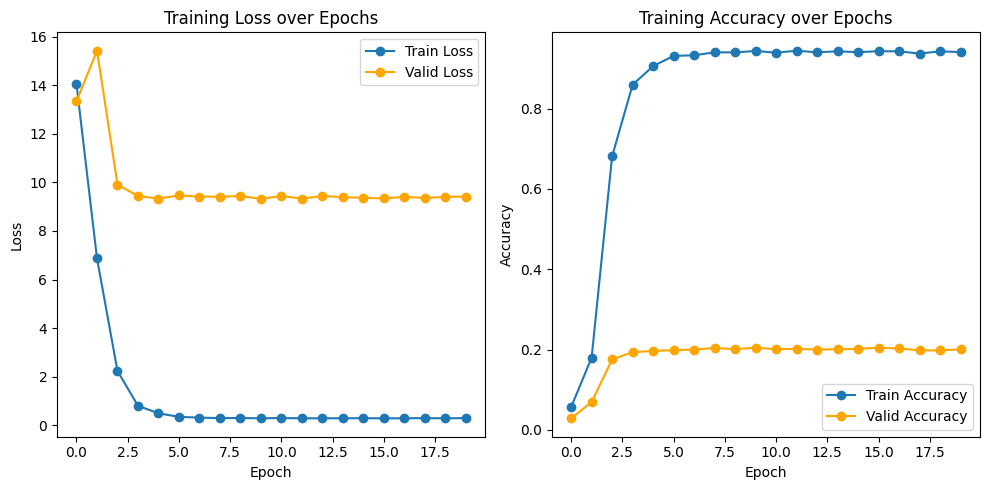

In [55]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(n_epochs), train_loss, label='Train Loss', marker='o')
plt.plot(range(n_epochs), valid_loss, label='Valid Loss', marker='o', color='orange')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Train Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(range(n_epochs), train_acc, label='Train Accuracy', marker='o')
plt.plot(range(n_epochs), valid_acc, label='Valid Accuracy', marker='o', color='orange')
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [56]:
model_conv.load_state_dict(torch.load('big_model_state.pt')) # 가장 좋았던 모델 값 불러오기.

<All keys matched successfully>

In [57]:
sub = pd.read_csv('C:/Users/COM/Desktop/hlsw/final_project_md/whale-categorization-playground/sample_submission.csv')

model_conv.eval()
model_conv.cuda()
for (data, target, name) in test_loader:
    data = data.cuda()
    output = model_conv(data)
    output = output.cpu().detach().numpy()
    for i, (e, n) in enumerate(list(zip(output, name))):
        sub.loc[sub['Image'] == n, 'Id'] = ' '.join(le.inverse_transform(e.argsort()[-5:][::-1]))
        
sub.to_csv('submission.csv', index=False)

In [58]:
model1 = models.resnet18(pretrained=True) # 모델의 객체 생성 
model1.fc = torch.nn.Linear(512,4251) # 전이학습
model1.load_state_dict(torch.load('resnet18_big_model_0.408_state.pt', map_location='cpu')) # 모델 값 불러오기.  # 모델1
model2 = models.resnet18(pretrained=True) # 모델의 객체 생성
model2.fc = torch.nn.Linear(512,4251) # 전이학습
model2.load_state_dict(torch.load('resnet18_big_model_0.4181_state.pt', map_location='cpu')) # 모델 값 불러오기.  # 모델2
model3 = models.resnet18(pretrained=True) # 모델의 객체 생성
model3.fc = torch.nn.Linear(512,4251) # 전이학습
model3.load_state_dict(torch.load('resnet18_big_model_0.41423_state.pt', map_location='cpu')) # 모델 값 불러오기.  # 모델3
model4 = models.resnet18(pretrained=True) # 모델의 객체 생성
model4.fc = torch.nn.Linear(512,4251) # 전이학습
model4.load_state_dict(torch.load('resnet18_big_model_0.42135_state.pt', map_location='cpu')) # 모델 값 불러오기.  # 모델4
model5 = models.resnet18(pretrained=True) # 모델의 객체 생성
model5.fc = torch.nn.Linear(512,4251) # 전이학습
model5.load_state_dict(torch.load('resnet18_big_model_0.42845_state.pt', map_location='cpu')) # 모델 값 불러오기.  # 모델5
model6 = models.resnet18(pretrained=True) # 모델의 객체 생성
model6.fc = torch.nn.Linear(512,4251) # 전이학습
model6.load_state_dict(torch.load('resnet18_big_model_0.42057_state.pt', map_location='cpu')) # 모델 값 불러오기.  # 모델6
model7 = models.resnet18(pretrained=True) # 모델의 객체 생성
model7.fc = torch.nn.Linear(512,4251) # 전이학습
model7.load_state_dict(torch.load('resnet18_big_model_0.41763_state.pt', map_location='cpu')) # 모델 값 불러오기.  # 모델7
model8 = models.resnet18(pretrained=True) # 모델의 객체 생성
model8.fc = torch.nn.Linear(512,4251) # 전이학습
model8.load_state_dict(torch.load('resnet18_big_model_0.42073_state.pt', map_location='cpu')) # 모델 값 불러오기.  # 모델8
model9 = models.resnet18(pretrained=True) # 모델의 객체 생성
model9.fc = torch.nn.Linear(512,4251) # 전이학습
model9.load_state_dict(torch.load('resnet18_big_model_0.41769_state.pt', map_location='cpu')) # 모델 값 불러오기.  # 모델9

c:\Users\COM\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\COM\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [59]:
model1.cuda()
model2.cuda()
model3.cuda()
model4.cuda()
model5.cuda()
model6.cuda()
model7.cuda()
model8.cuda()
model9.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [60]:
sub = pd.read_csv('C:/Users/COM/Desktop/hlsw/final_project_md/whale-categorization-playground/sample_submission.csv')

model1.eval()
model2.eval()
model3.eval()
model4.eval()
model5.eval()
model6.eval()
model7.eval()
model8.eval()
model9.eval()
for (data, target, name) in test_loader:
    data = data.cuda()
    output1 = model1(data)
    output2 = model2(data)
    output3 = model3(data)
    output4 = model4(data)
    output5 = model5(data)
    output6 = model6(data)
    output7 = model7(data)
    output8 = model8(data)
    output9 = model9(data)
    output1 = output1.cpu().detach().numpy()
    output2 = output2.cpu().detach().numpy()
    output3 = output3.cpu().detach().numpy()
    output4 = output4.cpu().detach().numpy()
    output5 = output5.cpu().detach().numpy()
    output6 = output6.cpu().detach().numpy()
    output7 = output7.cpu().detach().numpy()
    output8 = output8.cpu().detach().numpy()
    output9 = output9.cpu().detach().numpy()
    output = output1 + output2 + output3 + output4 + output5 + output6 + output7 + output8 + output9
    ensemble_output = torch.softmax(torch.tensor(output), dim=1).numpy()
    
    for i, (e, n) in enumerate(list(zip(ensemble_output, name))):
        sub.loc[sub['Image'] == n, 'Id'] = ' '.join(le.inverse_transform(e.argsort()[-5:][::-1]))
        
sub.to_csv('submission.csv', index=False)